**Import the packages**

In [11]:
import gymnasium as gym
from stable_baselines3 import DDPG, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import numpy as np
import base64
from PIL import Image
import io
import os
from openai import OpenAI
from openaikey import OPENAI_API_KEY
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3.common.logger import configure
import custom_parking
import imageio
from utils import record_videos, show_videos

**Defining Functions for Vision**

In [12]:
def env_render_to_base64(env):
    env.reset()
    rendered = env.render()
    # Convert numpy array to PIL Image
    image = Image.fromarray(rendered)

    # Save the image to a BytesIO object
    buffer = io.BytesIO()
    image.save(buffer, format='JPEG')

    # Get the content of the BytesIO object
    image_bytes = buffer.getvalue()

    # Encode the bytes to base64
    image_base64 = base64.b64encode(image_bytes)

    # If you need it as a string
    image_base64_str = image_base64.decode('utf-8')
    return image_base64_str

def prompt_api_vision(openai_client, prompt, image64) -> str:
    response = openai_client.chat.completions.create(
    model="gpt-4-turbo",
    messages = [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt,
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{image64}",
                "detail": "low"
            },
            },
        ],
        }
    ],
    max_tokens=600,
    )
    return response.choices[0].message.content

def prompt_api_no_vision(openai_client, prompt1) -> str:
    response = openai_client.chat.completions.create(
    model="gpt-4-turbo",
    messages = [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt1,
            },
        ],
        }
    ],
    max_tokens=600,
    )
    return response.choices[0].message.content

**Define Prompts for API and generate reward function**

In [15]:
# Create an OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

#getting render of the environment
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict = None, p: float = 0.5) -> float:
       return 0.0

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
env.reset()

image_base64_str = env_render_to_base64(env)

# PROMPTS FOR THE CLIENT
env_description = """
Here is an image of a top-down view of a parking lot. 
The green rectangle represents a car that can be controlled via throttle and steering angle.
The blue rectangle represents the goal parking spot.
Our we get a reward of 1 if the car is parked in the blue spot within 0.1 of the desired orientation, and 0 otherwise.
We would like to incentivize the car to quickly park in the blue spot with the correct orientation.
Our observations come in the form of:
OrderedDict([ 
             ('achieved_goal', array([ 0.,  0.,  0., -0.,  0.65025885, -0.75971273])),
             ('desired_goal', array([2.200000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00, 6.123234e-17, 1.000000e+00]))
            ])
Where each array corresponds to the following: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'] of the car's current state and desired state.
Please describe 5 behaviors in natural language that would incentivize an agent to efficiently learn how park as desired.
"""

language_to_code_prompt = """
You are an assistant tasked with turning language subgoals into machine readable code.
You are given this type of observation of a car trying to park in a parking lot. 
OrderedDict([ 
             ('achieved_goal', array([ 0.,  0.,  0., -0.,  0.65025885, -0.75971273])),
             ('desired_goal', array([2.200000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00, 6.123234e-17, 1.000000e+00]))
            ])
Where each array corresponds to the following: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'] of the car's current state and desired state.
Please use all information to define a reward function that incentivizes the behaviors described in the following list.
Please respond with only the code for the reward function which is defined by compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info = {}, p = 0.5) -> float:
The reward function should address each point in the following list:
""" 
# Our actions come in the form: [0.0, 0.0] where the first element is the steering angle and the second element is the throttle.
natural_language = language_to_code_prompt + prompt_api_vision(client, env_description, image_base64_str)
print(natural_language)
code = prompt_api_no_vision(client, language_to_code_prompt)
print(code)


You are an assistant tasked with turning language subgoals into machine readable code. 
OrderedDict([ 
             ('achieved_goal', array([ 0.,  0.,  0., -0.,  0.65025885, -0.75971273])),
             ('desired_goal', array([2.200000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00, 6.123234e-17, 1.000000e+00]))
            ])
Where each array corresponds to the following: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'] of the car's current state and desired state.
Please use all information to define a reward function that incentivizes the behaviors described in the following list.
Please respond with only the code for the reward function which is defined by compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info = {}, p = 0.5) -> float:
The reward function should address each point in the following list:
To effectively incentivize an autonomous agent to learn parking in the described simulation, you can tailor reinforcement learning with the following behaviors in the

In [6]:
# TODO REPLACE THE REWARD FUNCTION WITH THE GENERATED CODE
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, action: np.ndarray) -> float:
    # Extract positions and headings from the goal arrays
    x_a, y_a, _, _, cos_h_a, sin_h_a = achieved_goal
    x_d, y_d, _, _, cos_h_d, sin_h_d = desired_goal
    
    # Compute position and heading errors
    position_error = np.sqrt((x_a - x_d) ** 2 + (y_a - y_d) ** 2)
    heading_error = np.arccos(np.clip(cos_h_a * cos_h_d + sin_h_a * sin_h_d, -1.0, 1.0))
    
    # Penalize based on the distance and orientation
    position_penalty = -position_error
    heading_penalty = -np.abs(heading_error)  # should be small when oriented correctly
    
    # Calculate the control cost to discourage excessive use of controls
    steering_cost = -0.01 * abs(action[0])  # Small penalty for large steering angles
    throttle_cost = -0.01 * abs(action[1])  # Small penalty for aggressive throttle actions
    
    # Calculate total reward by combining all penalties and costs
    reward = position_penalty + heading_penalty + steering_cost + throttle_cost
    return reward

**CREATING ENV, AGENT, and TRAINING**

In [4]:
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
        return -np.power(np.dot(np.abs(achieved_goal - desired_goal), np.array(self.config["reward_weights"])), p)

mode = "USE_DDPG"
training_steps =100000

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
obs = env.reset()
print(env.observation_type_parking.observe())


# FOR DDPG
if mode == "USE_DDPG":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    #set noise for ddpg
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    # creating model and assign logger
    model = DDPG("MultiInputPolicy", env, verbose=2, action_noise=action_noise)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ddpg_parking_ai_reward")

# FOR PPO
if mode == "USE_PPO":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # creating model and assign logger
    model = PPO("MultiInputPolicy", env, verbose=1)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ppo_parking_ai_reward")



OrderedDict([('observation', array([ 0.        ,  0.        , -0.        , -0.        , -0.69259283,
       -0.72132875])), ('achieved_goal', array([ 0.        ,  0.        , -0.        , -0.        , -0.69259283,
       -0.72132875])), ('desired_goal', array([ 2.600000e-01, -1.400000e-01,  0.000000e+00,  0.000000e+00,
        6.123234e-17, -1.000000e+00]))])
Logging to wiley/log


/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_type_parking to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_type_parking` for environment variables or `env.get_wrapper_attr('observation_type_parking')` that will search the reminding wrappers.
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50.5     |
|    ep_rew_mean     | -26.9    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 94       |
|    time_elapsed    | 2        |
|    total_timesteps | 202      |
| train/             |          |
|    actor_loss      | 0.643    |
|    critic_loss     | 0.187    |
|    learning_rate   | 0.001    |
|    n_updates       | 101      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.2     |
|    ep_rew_mean     | -20.6    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 76       |
|    time_elapsed    | 3        |
|    total_timesteps | 298      |
| train/             |

**Loading Models and running simulation**

In [5]:
images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave("lander_a2c.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


In [ ]:
mode = "USE_DDPG"
env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
if mode == "USE_DDPG":
    model = DDPG.load("wiley/models/ddpg_parking_ai_reward", env=env)
if mode == "USE_PPO":
    model = PPO.load("wiley/models/ppo_parking_ai_reward", env=env)

images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave(f"car{mode}.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

**Plot Training Logs**

In [ ]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/success_rate'], label='Success Rate')
plt.xlabel('Timesteps')
plt.ylabel('Success Rate')
plt.title('Training Progress Using DDPG w/ Dense Dist')
plt.legend()
plt.show()

#### Sparse Reward


In [3]:
mode = "USE_DDPG"
training_steps =100000

def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
        weighted_diff = -np.power(np.dot(np.abs(achieved_goal - desired_goal), np.array(self.config["reward_weights"])), 0.5)
        if weighted_diff > -self.config["success_goal_reward"]:
                return 1.0
        else:
                return 0.0

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
obs = env.reset()
print(env.observation_type_parking.observe())


# FOR DDPG
if mode == "USE_DDPG":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    #set noise for ddpg
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    # creating model and assign logger
    model = DDPG("MultiInputPolicy", env, verbose=2, action_noise=action_noise)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ddpg_parking_sparse_reward")

OrderedDict([('observation', array([ 0.        ,  0.        , -0.        , -0.        , -0.92513802,
       -0.37963093])), ('achieved_goal', array([ 0.        ,  0.        , -0.        , -0.        , -0.92513802,
       -0.37963093])), ('desired_goal', array([ 2.200000e-01, -1.400000e-01,  0.000000e+00,  0.000000e+00,
        6.123234e-17, -1.000000e+00]))])
Logging to wiley/log


/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_type_parking to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_type_parking` for environment variables or `env.get_wrapper_attr('observation_type_parking')` that will search the reminding wrappers.
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 180      |
|    ep_rew_mean     | -3.75    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 63       |
|    time_elapsed    | 11       |
|    total_timesteps | 718      |
| train/             |          |
|    actor_loss      | 0.232    |
|    critic_loss     | 0.0471   |
|    learning_rate   | 0.001    |
|    n_updates       | 617      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 189      |
|    ep_rew_mean     | -3.75    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 60       |
|    time_elapsed    | 25       |
|    total_timesteps | 1513     |
| train/             |

Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


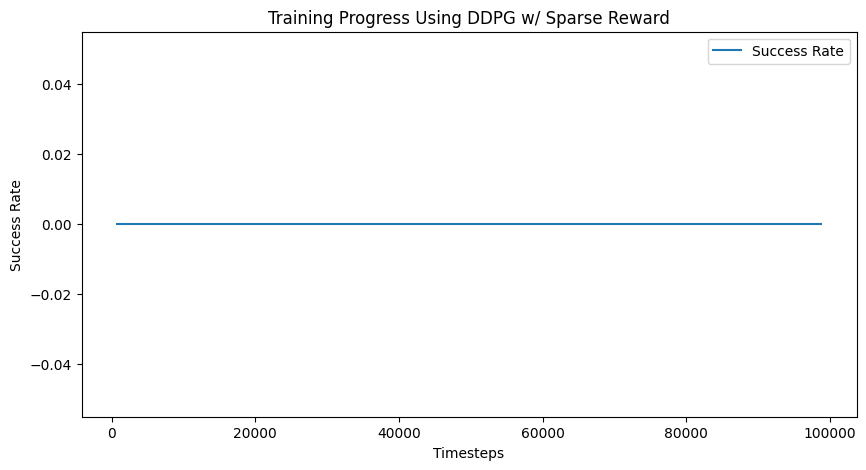

In [6]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/success_rate'], label='Success Rate')
plt.xlabel('Timesteps')
plt.ylabel('Success Rate')
plt.title('Training Progress Using DDPG w/ Sparse Reward')
plt.legend()
plt.show()

Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


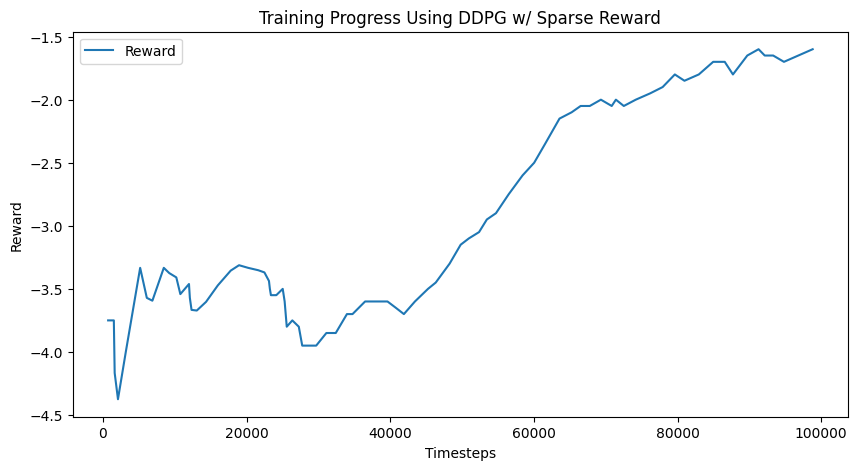

In [7]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/ep_rew_mean'], label='Reward')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.title('Training Progress Using DDPG w/ Sparse Reward')
plt.legend()
plt.show()

In [8]:
images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave("DDPG_Sparse.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


#### Distance Reward

In [9]:
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
        return -np.power(np.dot(np.abs(achieved_goal - desired_goal), np.array(self.config["reward_weights"])), p)

mode = "USE_DDPG"
training_steps =100000

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
obs = env.reset()
print(env.observation_type_parking.observe())


# FOR DDPG
if mode == "USE_DDPG":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    #set noise for ddpg
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    # creating model and assign logger
    model = DDPG("MultiInputPolicy", env, verbose=2, action_noise=action_noise)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ddpg_parking_ai_reward")

# FOR PPO
if mode == "USE_PPO":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # creating model and assign logger
    model = PPO("MultiInputPolicy", env, verbose=1)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ppo_parking_ai_reward")



OrderedDict([('observation', array([ 0.        ,  0.        , -0.        ,  0.        , -0.46683779,
        0.88434296])), ('achieved_goal', array([ 0.        ,  0.        , -0.        ,  0.        , -0.46683779,
        0.88434296])), ('desired_goal', array([1.800000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00,
       6.123234e-17, 1.000000e+00]))])
Logging to wiley/log


/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_type_parking to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_type_parking` for environment variables or `env.get_wrapper_attr('observation_type_parking')` that will search the reminding wrappers.
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 76       |
|    ep_rew_mean     | -41.2    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 71       |
|    time_elapsed    | 4        |
|    total_timesteps | 304      |
| train/             |          |
|    actor_loss      | 1.2      |
|    critic_loss     | 0.184    |
|    learning_rate   | 0.001    |
|    n_updates       | 203      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 53.2     |
|    ep_rew_mean     | -30      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 65       |
|    time_elapsed    | 6        |
|    total_timesteps | 426      |
| train/             |

Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


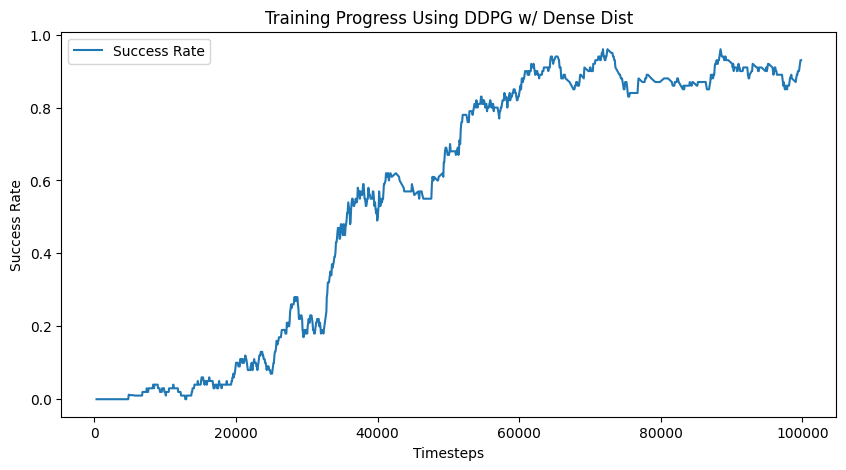

In [14]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/success_rate'], label='Success Rate')
plt.xlabel('Timesteps')
plt.ylabel('Success Rate')
plt.title('Training Progress Using DDPG w/ Dense Dist')
plt.legend()
plt.show()

Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


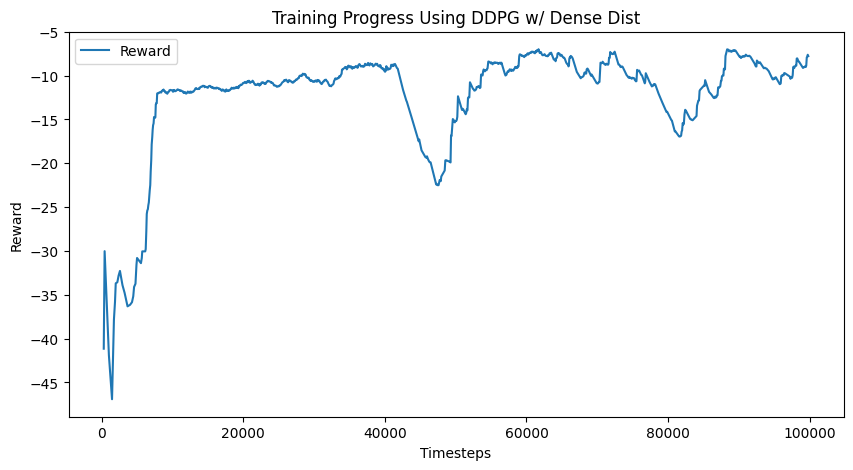

In [16]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/ep_rew_mean'], label='Reward')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.title('Training Progress Using DDPG w/ Dense Dist')
plt.legend()
plt.show()

#### LLM No action Input

In [23]:
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p = 0.5) -> float:
    # Constants for weight adjustments
    position_weight = 0.3
    velocity_weight = 0.2
    heading_weight = 0.5
    
    # Extract position and velocity components from the goals
    achieved_pos = achieved_goal[:2]  # x, y position
    desired_pos = desired_goal[:2]
    
    achieved_vel = achieved_goal[2:4]  # vx, vy velocities
    desired_vel = desired_goal[2:4]
    
    # Calculate heading from cos and sin components
    achieved_heading = np.arctan2(achieved_goal[5], achieved_goal[4])
    desired_heading = np.arctan2(desired_goal[5], desired_goal[4])

    # Position distance (Euclidean)
    position_error = np.linalg.norm(achieved_pos - desired_pos)
    
    # Velocity error (Euclidean)
    velocity_error = np.linalg.norm(achieved_vel - desired_vel)
    
    # Heading difference (ensure it is within -pi to pi)
    heading_diff = np.arctan2(np.sin(desired_heading - achieved_heading), np.cos(desired_heading - achieved_heading))
    
    # Compute the weighted sum of errors
    total_error = (position_weight * position_error +
                    velocity_weight * velocity_error +
                    heading_weight * abs(heading_diff))
    
    #Reward function inverse of error (more error lower reward)
    reward = -total_error

    return reward

mode = "USE_DDPG"
training_steps =100000

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
obs = env.reset()
print(env.observation_type_parking.observe())


# FOR DDPG
if mode == "USE_DDPG":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    #set noise for ddpg
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    # creating model and assign logger
    model = DDPG("MultiInputPolicy", env, verbose=2, action_noise=action_noise)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ddpg_parking_ai_reward")

# FOR PPO
if mode == "USE_PPO":
    # set up logger
    tmp_path = "wiley/log/llm_no_action" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # creating model and assign logger
    model = PPO("MultiInputPolicy", env, verbose=1)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ppo_parking_ai_reward_no_action")



OrderedDict([('observation', array([ 0.        ,  0.        , -0.        , -0.        , -0.91235548,
       -0.40939892])), ('achieved_goal', array([ 0.        ,  0.        , -0.        , -0.        , -0.91235548,
       -0.40939892])), ('desired_goal', array([-1.000000e-01, -1.400000e-01,  0.000000e+00,  0.000000e+00,
        6.123234e-17, -1.000000e+00]))])
Logging to wiley/log


/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_type_parking to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_type_parking` for environment variables or `env.get_wrapper_attr('observation_type_parking')` that will search the reminding wrappers.
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | -193     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 66       |
|    time_elapsed    | 7        |
|    total_timesteps | 514      |
| train/             |          |
|    actor_loss      | 4.09     |
|    critic_loss     | 0.0029   |
|    learning_rate   | 0.001    |
|    n_updates       | 413      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 238      |
|    ep_rew_mean     | -176     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 61       |
|    time_elapsed    | 31       |
|    total_timesteps | 1904     |
| train/             |

Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


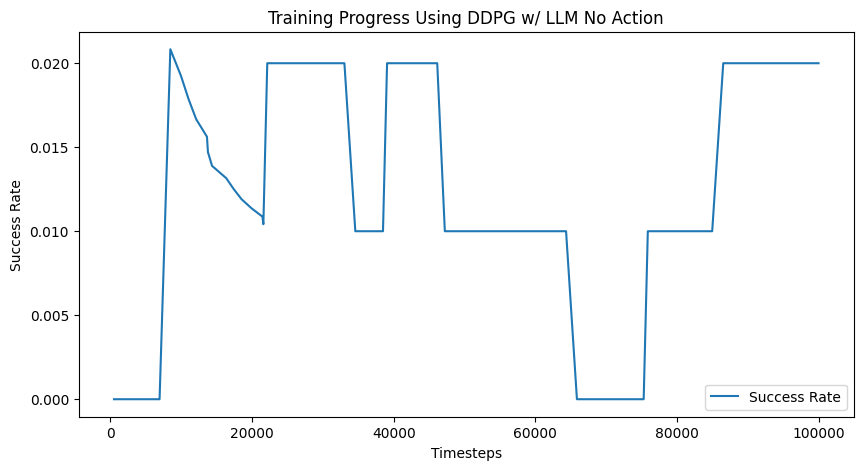

In [24]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/success_rate'], label='Success Rate')
plt.xlabel('Timesteps')
plt.ylabel('Success Rate')
plt.title('Training Progress Using DDPG w/ LLM No Action')
plt.legend()
plt.show()

Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


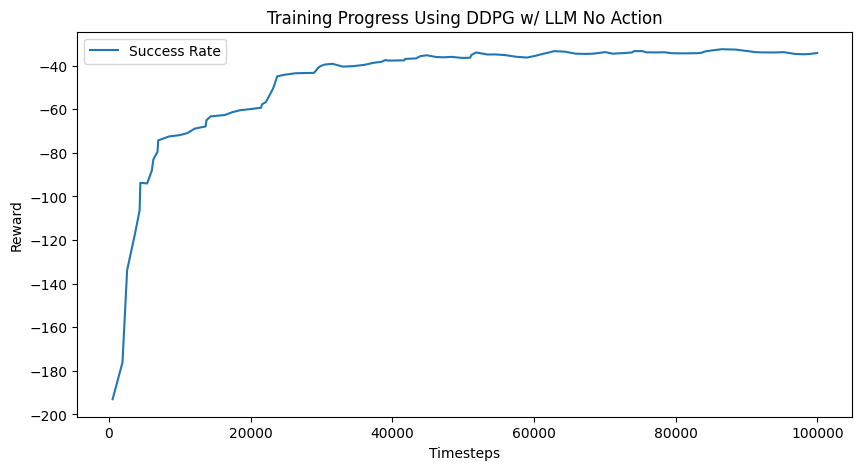

In [26]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/ep_rew_mean'], label='Success Rate')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.title('Training Progress Using DDPG w/ LLM No Action')
plt.legend()
plt.show()

In [28]:
# mode = "USE_DDPG"
# env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
# if mode == "USE_DDPG":
#     model = DDPG.load("wiley/models/ddpg_parking_ai_reward", env=env)
# if mode == "USE_PPO":
#     model = PPO.load("wiley/models/ppo_parking_ai_reward", env=env)

images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave(f"DDPG_LLM_no_action.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


#### LLM With Action

In [31]:
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, action: np.ndarray) -> float:
    # Extract car state components
    ax, ay, avx, avy, acos_h, asin_h = achieved_goal
    dx, dy, dvx, dvy, dcos_h, dsin_h = desired_goal
    
    # Calculate position difference
    pos_diff = np.sqrt((ax - dx)**2 + (ay - dy)**2)
    
    # Calculate velocity difference
    vel_diff = np.sqrt((avx - dvx)**2 + (avy - dvy)**2)
    
    # Calculate orientation difference using arc-cosine of dot product of unit orientation vectors
    orientation_diff = np.arccos(acos_h * dcos_h + asin_h * dsin_h)
    
    # Steering and throttle controls from the action
    steering, throttle = action
    
    # Define weights for different components of the reward
    w_pos = -1.0  # Weight for position difference
    w_vel = -0.1  # Weight for velocity difference
    w_ori = -0.1  # Weight for orientation difference
    w_steering = -0.05  # Penalty for large steering
    w_throttle = -0.05  # Penalty for high throttle usage
    
    # Calculate the reward components
    r_pos = w_pos * pos_diff
    r_vel = w_vel * vel_diff
    r_ori = w_ori * orientation_diff
    r_steering = w_steering * (steering**2)  # Squaring to penalize larger steering more
    r_throttle = w_throttle * (throttle**2)  # Squaring to penalize larger throttle more
    
    # Total reward
    reward = r_pos + r_vel + r_ori + r_steering + r_throttle
    
    return reward

mode = "USE_DDPG"
training_steps =100000

env = gym.make("CustomParkingWithAction-v0",  compute_reward=compute_reward, render_mode="rgb_array")
obs = env.reset()
print(env.observation_type_parking.observe())


# FOR DDPG
if mode == "USE_DDPG":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    #set noise for ddpg
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    # creating model and assign logger
    model = DDPG("MultiInputPolicy", env, verbose=2, action_noise=action_noise)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ddpg_parking_ai_reward")

# FOR PPO
if mode == "USE_PPO":
    # set up logger
    tmp_path = "wiley/log/llm_no_action" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # creating model and assign logger
    model = PPO("MultiInputPolicy", env, verbose=1)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ppo_parking_ai_reward_no_action")

OrderedDict([('observation', array([ 0.        ,  0.        , -0.        , -0.        , -0.99367256,
       -0.11231584])), ('achieved_goal', array([ 0.        ,  0.        , -0.        , -0.        , -0.99367256,
       -0.11231584])), ('desired_goal', array([-2.000000e-02,  1.400000e-01,  0.000000e+00,  0.000000e+00,
        6.123234e-17,  1.000000e+00]))])
Logging to wiley/log


/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_type_parking to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_type_parking` for environment variables or `env.get_wrapper_attr('observation_type_parking')` that will search the reminding wrappers.
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 65.8     |
|    ep_rew_mean     | -43.2    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 71       |
|    time_elapsed    | 3        |
|    total_timesteps | 263      |
| train/             |          |
|    actor_loss      | 1.14     |
|    critic_loss     | 0.164    |
|    learning_rate   | 0.001    |
|    n_updates       | 162      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 87.9     |
|    ep_rew_mean     | -44.1    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 59       |
|    time_elapsed    | 11       |
|    total_timesteps | 703      |
| train/             |

Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


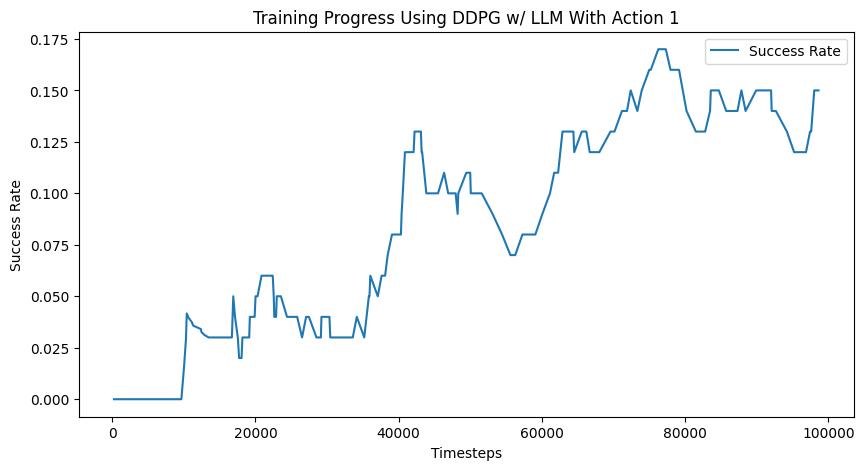

In [35]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/success_rate'], label='Success Rate')
plt.xlabel('Timesteps')
plt.ylabel('Success Rate')
plt.title('Training Progress Using DDPG w/ LLM With Action 1')
plt.legend()
plt.show()


Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


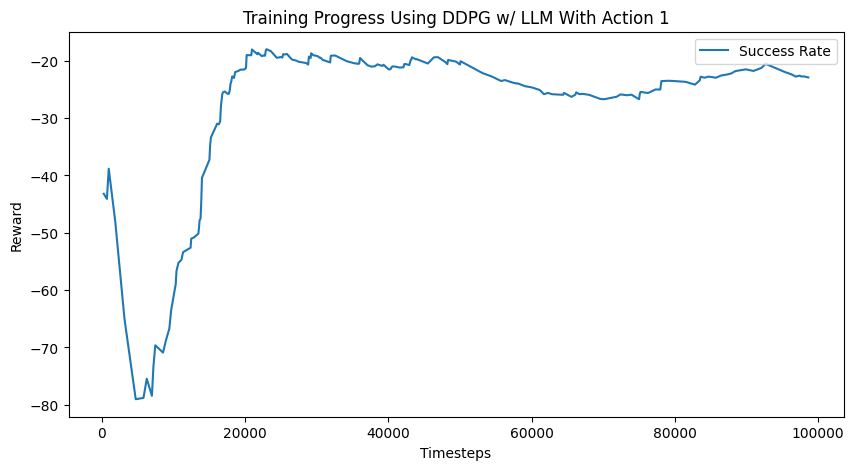

In [36]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/ep_rew_mean'], label='Success Rate')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.title('Training Progress Using DDPG w/ LLM With Action 1')
plt.legend()
plt.show()

In [38]:
images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave(f"DDPG_LLM_With_action.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


#### LLM WITH ACTION 2 200k

In [40]:
# def __init__(self):
#         # Constants for weighting different parts of the reward function
#         self.position_weight = 1.0
#         self.heading_weight = 1.0
#         self.control_weight = 0.01  # Assume small penalty for using controls heavily, to encourage efficient driving

def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, action: np.ndarray) -> float:
    # Extract positions and headings
    pos_achieved = achieved_goal[0:2]  # x, y
    pos_desired = desired_goal[0:2]  # x, y
    heading_achieved = achieved_goal[4:6]  # cos_h, sin_h
    heading_desired = desired_goal[4:6]  # cos_h, sin_h

    # Calculate position error (Euclidean distance)
    position_error = np.linalg.norm(pos_achieved - pos_desired)

    # Calculate heading error (angle between two vectors)
    dot_product = np.dot(heading_achieved, heading_desired)
    heading_error = np.arccos(np.clip(dot_product, -1.0, 1.0))  # Clip to handle numerical issues
    
    # Control usage penalty (negative reinforcement)
    control_penalty = np.sum(np.abs(action))

    # Combine the components of the reward
    reward = - (1.0 * position_error  # Minimize position error
                + 1.0 * heading_error  # Minimize heading error
                + 0.01 * control_penalty)  # Penalize heavy control use

    return reward

mode = "USE_DDPG"
training_steps = 200000

env = gym.make("CustomParkingWithAction-v0",  compute_reward=compute_reward, render_mode="rgb_array")
obs = env.reset()
print(env.observation_type_parking.observe())


# FOR DDPG
if mode == "USE_DDPG":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    #set noise for ddpg
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    # creating model and assign logger
    model = DDPG("MultiInputPolicy", env, verbose=2, action_noise=action_noise)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ddpg_parking_ai_reward")

# FOR PPO
if mode == "USE_PPO":
    # set up logger
    tmp_path = "wiley/log/llm_no_action" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # creating model and assign logger
    model = PPO("MultiInputPolicy", env, verbose=1)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ppo_parking_ai_reward_no_action")

OrderedDict([('observation', array([0.        , 0.        , 0.        , 0.        , 0.93281509,
       0.36035538])), ('achieved_goal', array([0.        , 0.        , 0.        , 0.        , 0.93281509,
       0.36035538])), ('desired_goal', array([1.000000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00,
       6.123234e-17, 1.000000e+00]))])
Logging to wiley/log


/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_type_parking to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_type_parking` for environment variables or `env.get_wrapper_attr('observation_type_parking')` that will search the reminding wrappers.
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.2     |
|    ep_rew_mean     | -182     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 65       |
|    time_elapsed    | 5        |
|    total_timesteps | 389      |
| train/             |          |
|    actor_loss      | 3.83     |
|    critic_loss     | 0.0142   |
|    learning_rate   | 0.001    |
|    n_updates       | 288      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 125      |
|    ep_rew_mean     | -174     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 57       |
|    time_elapsed    | 17       |
|    total_timesteps | 998      |
| train/             |

Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


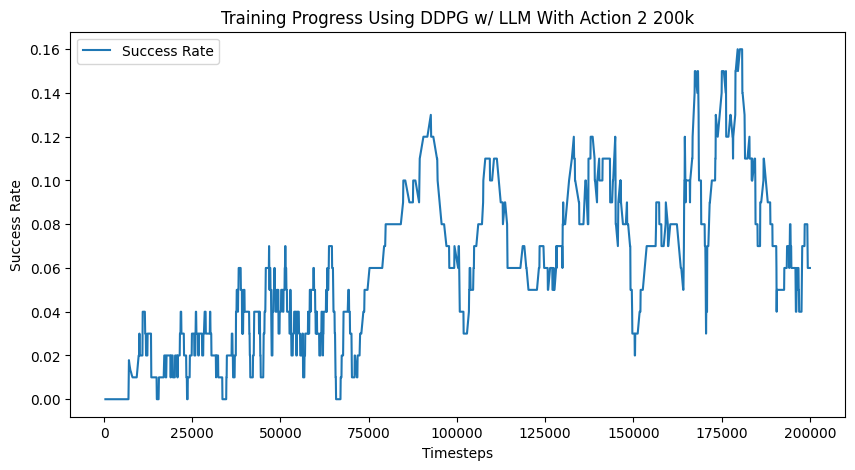

In [3]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/success_rate'], label='Success Rate')
plt.xlabel('Timesteps')
plt.ylabel('Success Rate')
plt.title('Training Progress Using DDPG w/ LLM With Action 2 200k')
plt.legend()
plt.show()

Index(['rollout/ep_rew_mean', 'time/episodes', 'train/n_updates',
       'time/time_elapsed', 'rollout/success_rate', 'train/actor_loss',
       'time/total_timesteps', 'train/critic_loss', 'train/learning_rate',
       'time/fps', 'rollout/ep_len_mean'],
      dtype='object')


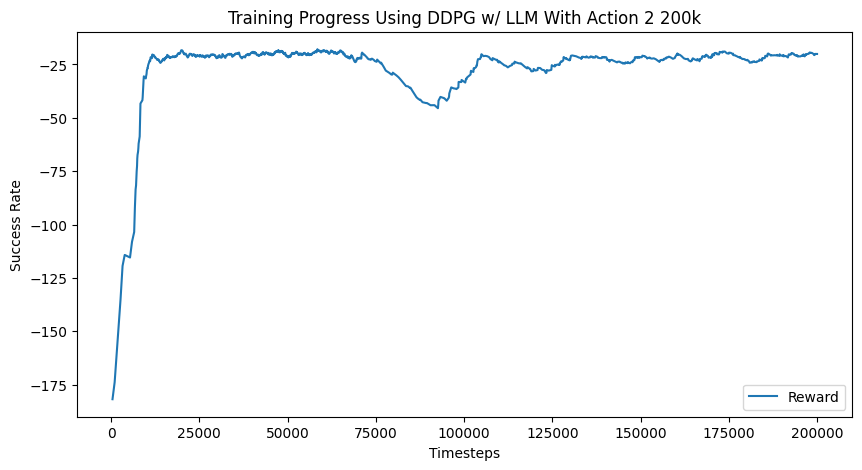

In [4]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/ep_rew_mean'], label='Reward')
plt.xlabel('Timesteps')
plt.ylabel('Success Rate')
plt.title('Training Progress Using DDPG w/ LLM With Action 2 200k')
plt.legend()
plt.show()

In [7]:
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, action: np.ndarray) -> float:
    # Extract positions and headings
    pos_achieved = achieved_goal[0:2]  # x, y
    pos_desired = desired_goal[0:2]  # x, y
    heading_achieved = achieved_goal[4:6]  # cos_h, sin_h
    heading_desired = desired_goal[4:6]  # cos_h, sin_h

    # Calculate position error (Euclidean distance)
    position_error = np.linalg.norm(pos_achieved - pos_desired)

    # Calculate heading error (angle between two vectors)
    dot_product = np.dot(heading_achieved, heading_desired)
    heading_error = np.arccos(np.clip(dot_product, -1.0, 1.0))  # Clip to handle numerical issues
    
    # Control usage penalty (negative reinforcement)
    control_penalty = np.sum(np.abs(action))

    # Combine the components of the reward
    reward = - (1.0 * position_error  # Minimize position error
                + 1.0 * heading_error  # Minimize heading error
                + 0.01 * control_penalty)  # Penalize heavy control use

    return reward

env = gym.make("CustomParkingWithAction-v0",  compute_reward=compute_reward, render_mode="rgb_array")
model = DDPG.load('wiley/models/ddpg_parking_ai_reward', env = env)

images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave(f"DDPG_LLM_ACTION2.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


#### LLM No Act 2

In [16]:
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info={}, p=0.5) -> float:
        # Reward function components:
        # 1. Euclidean distance for position (x, y):
        pos_distance = np.linalg.norm(achieved_goal[:2] - desired_goal[:2])

        # 2. Velocity (vx, vy) should possibly be low to avoid high speeds in critical situations, not fully defined:
        vel_achieved = np.linalg.norm(achieved_goal[2:4])
        vel_desired = np.linalg.norm(desired_goal[2:4])
        vel_distance = np.abs(vel_achieved - vel_desired)

        # 3. Orientation difference based on (cos_h, sin_h) angle representation:
        ang_diff = np.arccos(np.clip(np.dot(achieved_goal[4:6], desired_goal[4:6]), -1.0, 1.0))

        # Summarize the components into a final reward
        # Negative reward based on distance and angular difference, positive reward decreased by squared velocity difference
        reward = -p * (pos_distance + 0.1 * vel_distance + 2 * ang_diff)
        return reward

mode = "USE_DDPG"
training_steps =100000

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
obs = env.reset()
print(env.observation_type_parking.observe())


# FOR DDPG
if mode == "USE_DDPG":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    #set noise for ddpg
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    # creating model and assign logger
    model = DDPG("MultiInputPolicy", env, verbose=2, action_noise=action_noise)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ddpg_parking_ai_reward")

OrderedDict([('observation', array([ 0.        ,  0.        , -0.        ,  0.        , -0.19805344,
        0.98019122])), ('achieved_goal', array([ 0.        ,  0.        , -0.        ,  0.        , -0.19805344,
        0.98019122])), ('desired_goal', array([1.400000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00,
       6.123234e-17, 1.000000e+00]))])
Logging to wiley/log


/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_type_parking to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_type_parking` for environment variables or `env.get_wrapper_attr('observation_type_parking')` that will search the reminding wrappers.
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49.2     |
|    ep_rew_mean     | -105     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 94       |
|    time_elapsed    | 2        |
|    total_timesteps | 197      |
| train/             |          |
|    actor_loss      | 2.68     |
|    critic_loss     | 0.178    |
|    learning_rate   | 0.001    |
|    n_updates       | 96       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.4     |
|    ep_rew_mean     | -89      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 75       |
|    time_elapsed    | 4        |
|    total_timesteps | 315      |
| train/             |

Index(['time/fps', 'rollout/ep_len_mean', 'time/time_elapsed',
       'train/critic_loss', 'train/n_updates', 'time/total_timesteps',
       'rollout/success_rate', 'rollout/ep_rew_mean', 'train/actor_loss',
       'train/learning_rate', 'time/episodes'],
      dtype='object')


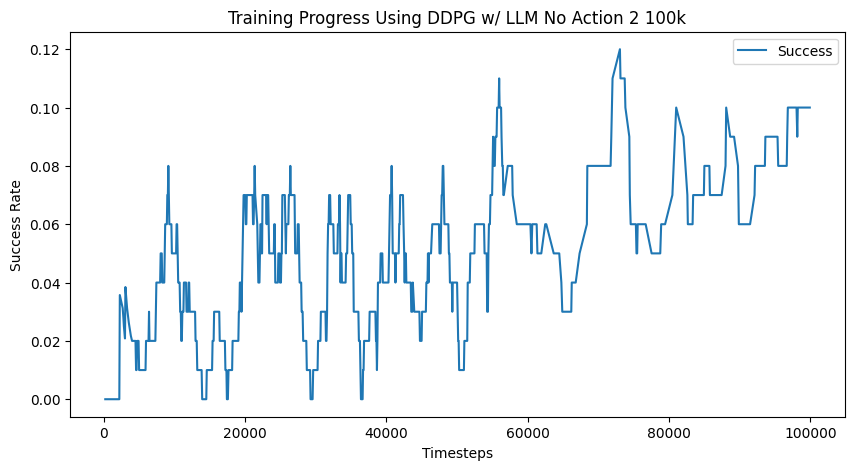

In [18]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/success_rate'], label='Success')
plt.xlabel('Timesteps')
plt.ylabel('Success Rate')
plt.title('Training Progress Using DDPG w/ LLM No Action 2 100k')
plt.legend()
plt.show()

Index(['time/fps', 'rollout/ep_len_mean', 'time/time_elapsed',
       'train/critic_loss', 'train/n_updates', 'time/total_timesteps',
       'rollout/success_rate', 'rollout/ep_rew_mean', 'train/actor_loss',
       'train/learning_rate', 'time/episodes'],
      dtype='object')


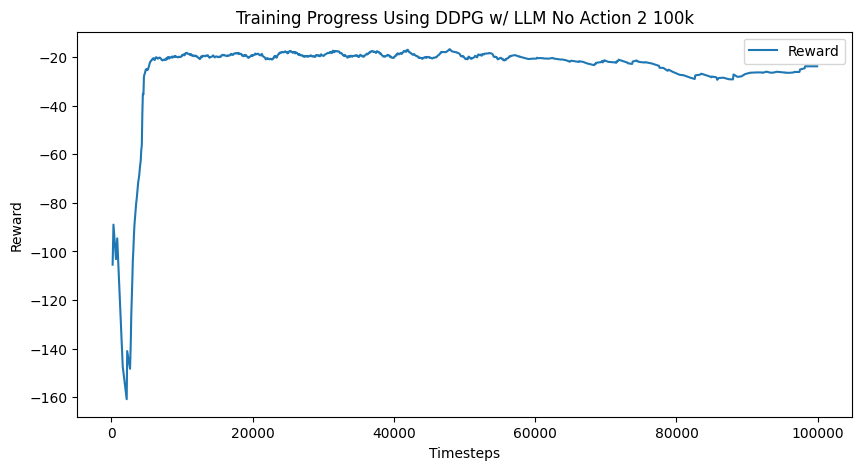

In [19]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/ep_rew_mean'], label='Reward')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.title('Training Progress Using DDPG w/ LLM No Action 2 100k')
plt.legend()
plt.show()

In [20]:
images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave(f"DDPG_LLM_NoA2.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


: 